<a href="https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/Energy_loss_non_gaussian_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install


In [33]:
pip install mbtrack2

# Setup ring, impedance and cavities

In [34]:
import numpy as np
from mbtrack2 import BeamLoadingEquilibrium, CavityResonator, Electron, Optics, Synchrotron, BeamLoadingEquilibrium, CircularResistiveWall, ImpedanceModel
from scipy.constants import c
import matplotlib.pyplot as plt

## Ring

In [35]:
def v2366_v3(IDs="open", V_RF=1.7e6, HC_power=50e3):
    """
    TDR lattice v2366 w/ RF parameters from November 2023 RF budget.
    Natural emittance and 1% coupling because of Synchrotron Radiation
    implementation.

    Parameters
    ----------
    IDs : {"open","close","close_phase2", "close_phase2_margin"}, optional
        ID configuration to consider.
        "open": bare lattice
        "close": ID phase 1
        "close_phase2": ID phase 2
        "close_phase2_margin": ID phase 2 + 15 % margin
        The default is "open".
    V_RF : float, optional
        Total RF voltage in [V].
        The default is 1.7e6.
    HC_power : float, optional
        HC dissipated power at 500 mA.
        Should be taken as 0 if the HC dissipation is taken into account in the
        simulation, for example by simulating the HC as a CavityResonator.
        The default is 50e3.

    Returns
    -------
    ring : Synchrotron object
        TDR lattice v2366_v3.

    """
    L = 353.97
    E0 = 2.75e9
    particle = Electron()
    ac = 1.05751e-04
    tune = np.array([54.2, 18.3])
    chro = np.array([1.6, 1.6])
    beta = np.array([3.288, 4.003])
    alpha = np.array([0, 0])
    dispersion = np.array([0, 0, 0, 0])
    h = 416
    particle = Electron()
    mcf_order = np.array([-0.00192226,  0.00061511,  0.00010695])

    U0 = 469e3 + HC_power*2

    if IDs == "open":
        tau = np.array([7.64e-3, 13.83e-3, 11.64e-3])
        sigma_delta = 9.063e-4
        emit = np.array([83.7e-12, 83.7e-12*0.01])
    elif IDs == "close":
        U0 += 136e3*2
        tau = np.array([5.78e-3, 8.75e-3, 5.89e-3])
        sigma_delta = 8.547e-4
        emit = np.array([66.2e-12, 66.2e-12*0.01])
    elif IDs == "close_phase2":
        U0 += 169e3*2
        tau = np.array([5.46e-3, 8.04e-3, 5.25e-3])
        sigma_delta = 8.770e-4
        emit = np.array([60.9e-12, 60.9e-12*0.01])
    elif IDs == "close_phase2_margin":
        U0 += 195e3*2
        tau = np.array([5.46e-3, 8.04e-3, 5.25e-3])
        sigma_delta = 8.770e-4
        emit = np.array([60.9e-12, 60.9e-12*0.01])
    else:
        raise ValueError("Invalid ID configuration")

    optics = Optics(local_beta=beta, local_alpha=alpha,
                  local_dispersion=dispersion)
    ring = Synchrotron(h, optics, particle, L=L, E0=E0, ac=ac, U0=U0, tau=tau,
                   emit=emit, tune=tune, sigma_delta=sigma_delta, chro=chro,
                   mcf_order=mcf_order)

    tuneS = ring.synchrotron_tune(V_RF)
    ring.sigma_0 = (ring.sigma_delta * np.abs(ring.eta())
                    / (tuneS * 2 * np.pi * ring. f0))
    ring.get_longitudinal_twiss(V_RF)

    return ring

## Cavities

In [36]:
Vc = 1.7e6
ring = v2366_v3(IDs="open", V_RF=Vc, HC_power=0)
I0 = 0.5

MC = CavityResonator(ring, m=1, Rs=5e6, Q=35.7e3, QL=6e3, detune=1e6, Ncav=4)
MC.Vc = Vc
MC.theta = np.arccos(ring.U0/MC.Vc)

MC.Vc = Vc
MC.theta = np.arccos(ring.U0/MC.Vc)
MC.set_optimal_detune(I0)
MC.set_generator(I0)

# Change HC detuning value here value
#HC_detuning = 86.5e3 # min stable value - max bunch length
HC_detuning = 90e3
#HC_detuning = 100e6 # unrealisitic large value to get zero current bunch length
# Change HC detuning value here value

HHC = CavityResonator(ring, m=4, Rs=30*31e3, Q=31e3, QL=31e3, detune=HC_detuning, Ncav=2)

## Impedance

<Axes: xlabel='frequency [Hz]', ylabel='$Z_{long}$ [ohm]'>

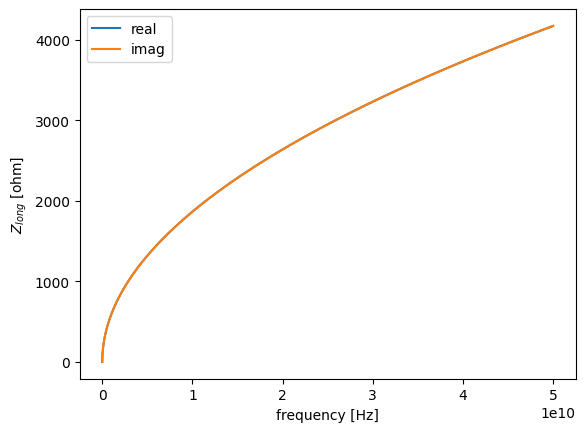

In [37]:
time = np.linspace(-1e-12, 100e-12, 100)
frequency = np.linspace(100, 50e9, int(1e6))
rw = CircularResistiveWall(time, frequency, length=ring.L, rho=1e-6, radius=6e-3)

model = ImpedanceModel(ring)
model.add_global(rw, "rw")
model.compute_sum()

model.sum.Zlong.plot()

# Get longitudinal equilibrium

Cavity detuning = 90.0 kHz
Cavity tuning angle = 75.82508076353183 deg
RMS bunch length = 47.53512126255546 ps


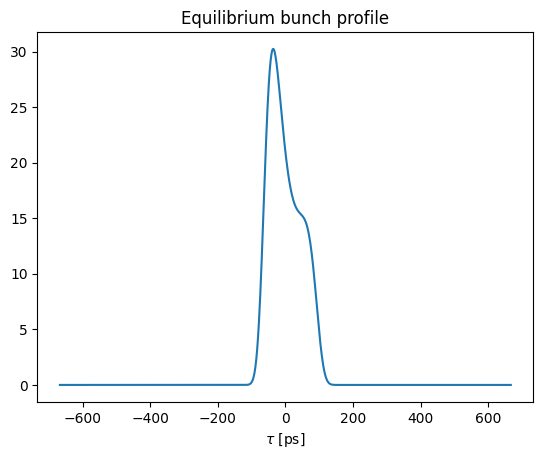

In [38]:
V = BeamLoadingEquilibrium(ring,[MC,HHC], I0, auto_set_MC_theta=True)
sol = V.beam_equilibrium(plot=True)
print(f"Cavity detuning = {HHC.detune*1e-3} kHz")
print(f"Cavity tuning angle = {HHC.psi*180/np.pi} deg")
print(f"RMS bunch length = {V.std_rho()/c*1e12} ps")

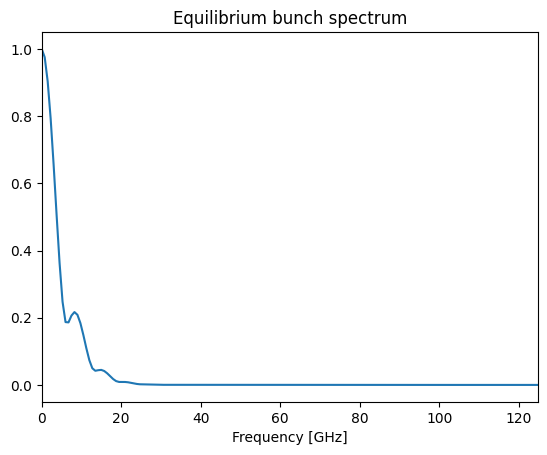

In [39]:
V.plot_bunch_spectrum()

# Compute energy loss and power spectrum

## energy loss

In [40]:
el = model.energy_loss(M=ring.h, bunch_spacing=ring.T1, I=0.5, freq_spectrum=V.freq0, bunch_spectrum=V.bunch_spectrum)

print(el["P (bunch) [W]"])
print(el["P (beam) [W]"])

rw    3404.421813
Name: P (bunch) [W], dtype: float64
rw    3366.636421
Name: P (beam) [W], dtype: float64


## power spectrum

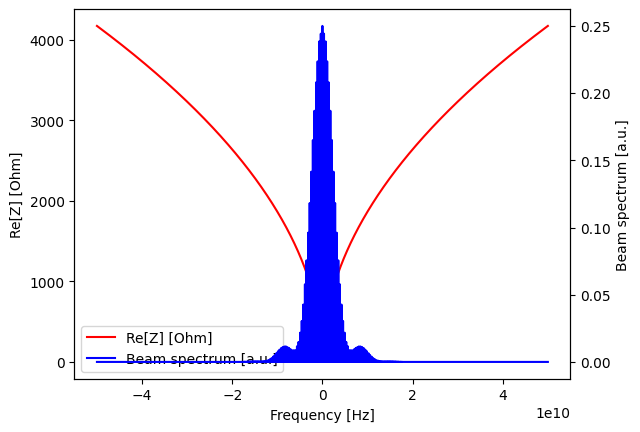

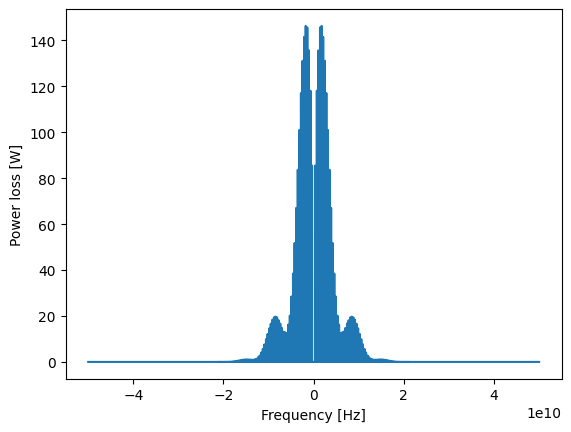

In [41]:
pf0, power_loss = model.power_loss_spectrum(M=ring.h, bunch_spacing=ring.T1, I=0.5, plot=True, freq_spectrum=V.freq0, bunch_spectrum=V.bunch_spectrum)